# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

Main reference: [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

# Homework 3 - Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for  solving reinforcement learning problems. The basic tasks for the homework will require to implement some  extensions to the code that you have seen in the Lab. The advanced tasks will require to train and test your  learning agent on a different type of input (image pixels) or Gym environment. You can just choose one of  the advanced tasks to get the maximum grade. If you are interested in improving your skills, feel free to try  both advanced tasks. Given the higher computational complexity of RL, in this homework you don’t need to  tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged  to play with model hyperparameters to find a satisfactory configuration. 



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The  student can explore additional libraries and tools to implement the models; however, please make sure you  understand the code you are writing because during the exam you might receive specific questions related  to your implementation. The entire source code required to run the homework must be uploaded as a  compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included  in a single Python notebook, just upload the notebook file. 


## Final report
 Along with the source code, you must separately upload a PDF file containing a brief report of  your homework. The report should include a brief Introduction on which you explain the homework goals  and the main implementation strategies you choose, a brief Method section where you describe your  model architectures and hyperparameters, and a Result section where you present the simulation results.  Total length must not exceed 6 pages, though you can include additional tables and figures in a final  Appendix (optional). The report must be self-contained, so please make sure that all relevant results are  explicitly included in the report / notebook. Given the dynamical nature of RL problems, you can explore  more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be 8 points. Points will be assigned based on the correct  implementation of the following items: 

- 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or  softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward  function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes). 

- 5 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using  directly the screen pixels, rather than the compact state representation used during the Lab (cart  position, cart velocity, pole angle, pole angular velocity). NB: this will require to change the  “observation_space” and to look for smart ways of encoding the pixels in a compact way to reduce  computational complexity (e.g., crop the image around the pole, use difference of consecutive frames  as input to consider temporal context, etc.). or 

- 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym  environment you like from the available list, or even explore other simulation platforms. 



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Libraries

In [1]:
#!pip install gym[all]

In [2]:
import random
import torch
import numpy as np
import gym
import cv2
import torch
import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets
import atari_py
import time
import cv2

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memory

seed = 101325

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


from google.colab import drive
drive.mount('/content/drive')

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [4]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [5]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [6]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
        #return self.memory

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(5, 5, 5, 5), (3, 3, 3, 3)]


# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh). 

Be sure to keep a linear output activation.

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=action_space_dim),
            #nn.Tanh(),
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    epsilon = max(epsilon, 0.05) # set a minimum to espsilon for numerical stability
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.02667262  0.06578369]


#### Exploration profile 

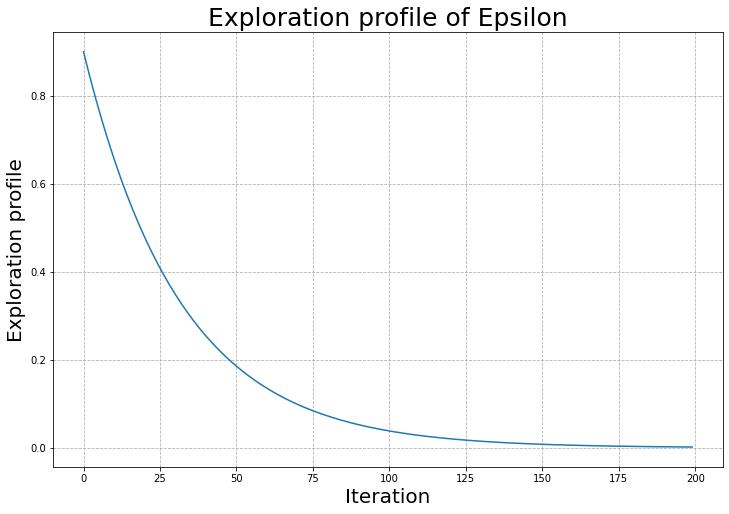

In [ ]:
### Define exploration profile
initial_value = 0.9
num_iterations = 200
# We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exp_decay = np.exp(np.log(initial_value) / num_iterations * 60)
exploration_profile_epsilon = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile_epsilon)
plt.grid(linestyle='--')
plt.title('Exploration profile of Epsilon', fontsize=25)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Exploration profile', fontsize=20);

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.02667262  0.06578369]


#### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

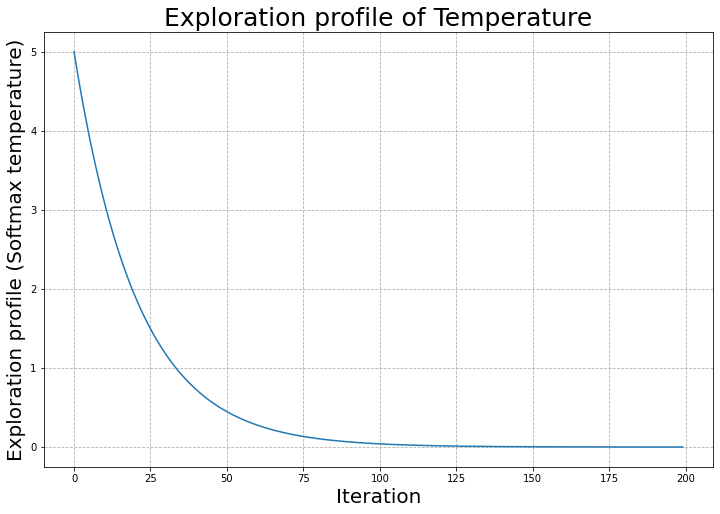

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 200
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile_softmax = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile_softmax)
plt.grid(linestyle='--')
plt.title('Exploration profile of Temperature', fontsize=25)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Exploration profile (Softmax temperature)', fontsize=20);

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

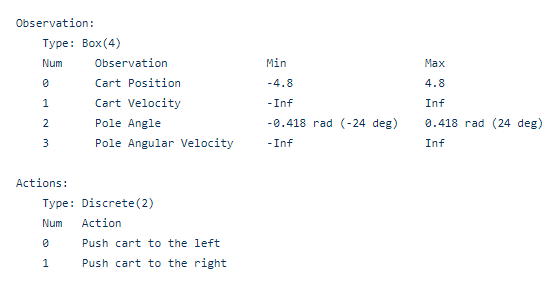

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(seed) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True)
history = [0]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    history.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()

EPISODE 1 - FINAL SCORE: 15.0
EPISODE 2 - FINAL SCORE: 35.0
EPISODE 3 - FINAL SCORE: 28.0
EPISODE 4 - FINAL SCORE: 13.0
EPISODE 5 - FINAL SCORE: 22.0
EPISODE 6 - FINAL SCORE: 42.0
EPISODE 7 - FINAL SCORE: 35.0
EPISODE 8 - FINAL SCORE: 16.0
EPISODE 9 - FINAL SCORE: 32.0
EPISODE 10 - FINAL SCORE: 20.0


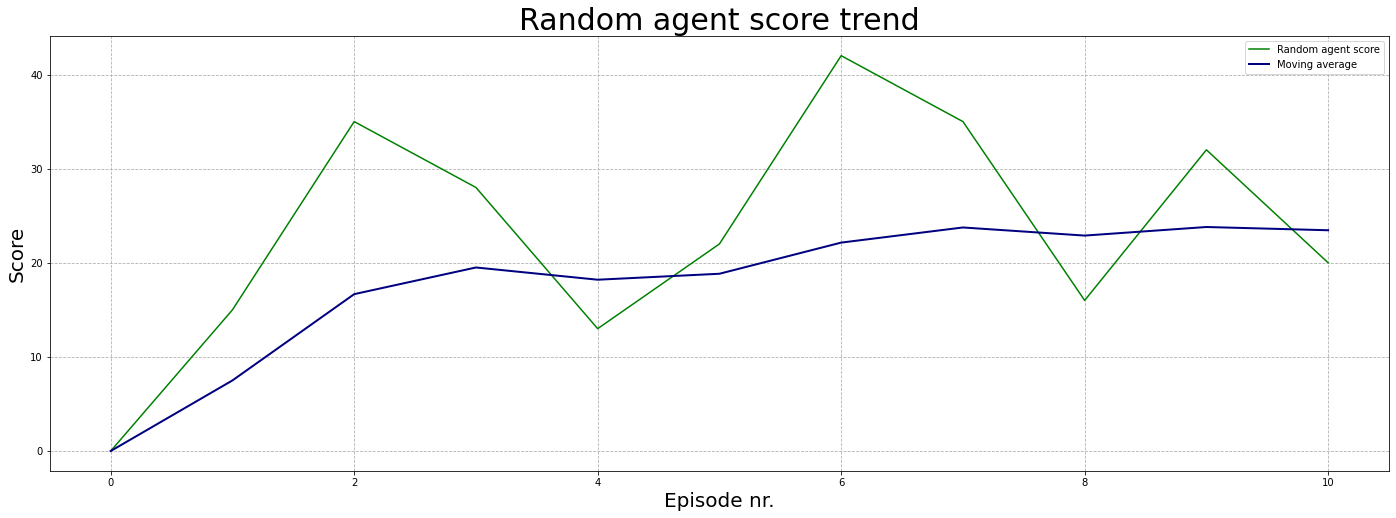

In [ ]:
ave = np.cumsum(history)/np.arange(1,len(history)+1,1)

plt.figure(figsize=(24,8))
plt.plot(history, color='green', label='Random agent score')
plt.plot(ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend()
plt.title('Random agent score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 5000   # Replay memory capacity
lr = 5e-3   # Optimizer learning rate
target_net_update_steps = 5   # Number of episodes to wait before updating the target network
batch_size = 32   # Number of samples to take from the replay memory for each update
min_samples_for_training = 100   # Minimum samples in the replay memory to enable the training

bad_state_penalty = -100   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 

final_eps = 0.05

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32)
    actions     = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop (first version)
Reward is not updated

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
history = [0]
for episode_num, tau in enumerate((exploration_profile_softmax)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += 0 #bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    history.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 4.764319787410581
EPISODE: 3 - FINAL SCORE: 26 - Temperature: 4.539748607342401
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 4.325762823966205
EPISODE: 5 - FINAL SCORE: 39 - Temperature: 4.121863483573453
Updating target network...
EPISODE: 6 - FINAL SCORE: 19 - Temperature: 3.927575151158822
EPISODE: 7 - FINAL SCORE: 12 - Temperature: 3.7424448018416157
EPISODE: 8 - FINAL SCORE: 24 - Temperature: 3.566040764541176
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 3.3979517154432557
EPISODE: 10 - FINAL SCORE: 35 - Temperature: 3.2377857189104065
Updating target network...
EPISODE: 11 - FINAL SCORE: 33 - Temperature: 3.0851693136000486
EPISODE: 12 - FINAL SCORE: 16 - Temperature: 2.939746641659326
EPISODE: 13 - FINAL SCORE: 41 - Temperature: 2.801178618966266
EPISODE: 14 - FINAL SCORE: 36 - Temperature: 2.6691421444824845
EPISODE: 15 - FINAL SCORE: 17 - Temperature: 2.54332934

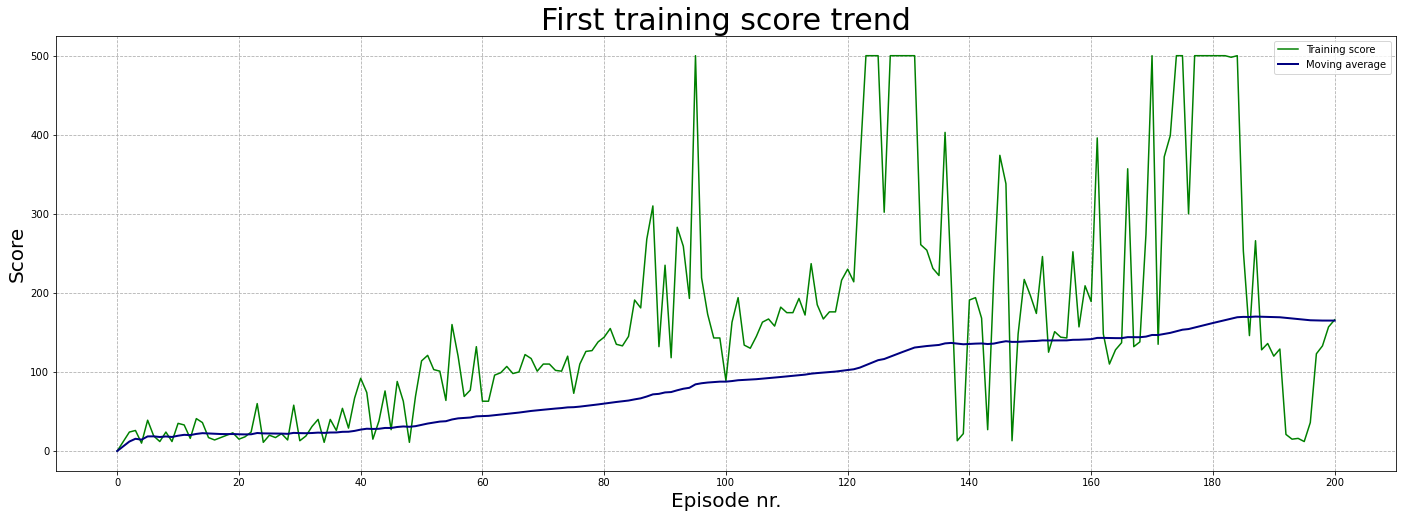

In [ ]:
soft_ave = np.cumsum(history)/np.arange(1,len(history)+1,1)

plt.figure(figsize=(24,8))
plt.plot(history, color='green', label='Training score')
plt.plot(soft_ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend()
plt.xticks(np.arange(0,len(exploration_profile_softmax)+1,20))
plt.title('First training score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

##### Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
# Set a random seeds (reproducible results)
env.seed(seed) 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
solved = 'solved'

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    if score <= 195 : solved = 'not solved'
env.close()

print('\nThe game is', solved)

EPISODE 1 - FINAL SCORE: 183.0
EPISODE 2 - FINAL SCORE: 178.0
EPISODE 3 - FINAL SCORE: 179.0
EPISODE 4 - FINAL SCORE: 198.0
EPISODE 5 - FINAL SCORE: 177.0
EPISODE 6 - FINAL SCORE: 185.0
EPISODE 7 - FINAL SCORE: 182.0
EPISODE 8 - FINAL SCORE: 177.0
EPISODE 9 - FINAL SCORE: 171.0
EPISODE 10 - FINAL SCORE: 159.0
EPISODE 11 - FINAL SCORE: 194.0
EPISODE 12 - FINAL SCORE: 168.0
EPISODE 13 - FINAL SCORE: 169.0
EPISODE 14 - FINAL SCORE: 172.0
EPISODE 15 - FINAL SCORE: 177.0
EPISODE 16 - FINAL SCORE: 183.0
EPISODE 17 - FINAL SCORE: 172.0
EPISODE 18 - FINAL SCORE: 178.0
EPISODE 19 - FINAL SCORE: 190.0
EPISODE 20 - FINAL SCORE: 181.0
EPISODE 21 - FINAL SCORE: 172.0
EPISODE 22 - FINAL SCORE: 166.0
EPISODE 23 - FINAL SCORE: 188.0
EPISODE 24 - FINAL SCORE: 168.0
EPISODE 25 - FINAL SCORE: 171.0
EPISODE 26 - FINAL SCORE: 183.0
EPISODE 27 - FINAL SCORE: 175.0
EPISODE 28 - FINAL SCORE: 184.0
EPISODE 29 - FINAL SCORE: 172.0
EPISODE 30 - FINAL SCORE: 192.0
EPISODE 31 - FINAL SCORE: 170.0
EPISODE 32 - FINA

## Training loop (advanced)
Let's modify the reward to improve the results.

### Find best policy

#### Softmax policy

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Initialize the Gym environment
start = time.time()
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes
history_s = []
completed = -1
for episode_num, tau in enumerate(tqdm(exploration_profile_softmax)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      state_weight = [-100, -50, 0, -100]
      reward += state_weight[0] * np.abs(state[0]) # cart position
      reward += state_weight[1] * np.abs(state[1]) # cart velocity
      reward += state_weight[2] * np.abs(state[2]) # pole angle
      reward += state_weight[3] * np.abs(state[3]) # pole angle velocity
      if done: 
        reward += bad_state_penalty # bad penalty if pole has fallen down
        next_state = None
      else: reward += 0 # positive reward if it is still alive


      # Update the final score (+1 for each step)
      score += 1

      # Update the replay memorym])
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    history_s.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    if (score == 500) &  (completed < 0):
        torch.save(policy_net.state_dict(), './soft_cartpolev1.pth')
        completed = episode_num + 1
env.close()
end = time.time()

print(f'\nTotal training time: %0.3f' %(end-start))
print(f'Completed in: %0.0f episodes' %completed)
print(f'Final score: %0.1f' %history_s[-1])
      

  0%|          | 0/200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 4.764319787410581
EPISODE: 3 - FINAL SCORE: 26 - Temperature: 4.539748607342401
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 4.325762823966205
EPISODE: 5 - FINAL SCORE: 39 - Temperature: 4.121863483573453
Updating target network...
EPISODE: 6 - FINAL SCORE: 10 - Temperature: 3.927575151158822
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 3.7424448018416157
EPISODE: 8 - FINAL SCORE: 9 - Temperature: 3.566040764541176
EPISODE: 9 - FINAL SCORE: 9 - Temperature: 3.3979517154432557
EPISODE: 10 - FINAL SCORE: 8 - Temperature: 3.2377857189104065
Updating target network...
EPISODE: 11 - FINAL SCORE: 10 - Temperature: 3.0851693136000486
EPISODE: 12 - FINAL SCORE: 49 - Temperature: 2.939746641659326
EPISODE: 13 - FINAL SCORE: 57 - Temperature: 2.801178618966266
EPISODE: 14 - FINAL SCORE: 45 - Temperature: 2.6691421444824845
EPISODE: 15 - FINAL SCORE: 63 - Temperature: 2.543329346873

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

##### Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
# Set a random seeds (reproducible results)
env.seed(seed) 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
solved = 'solved'

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    if score <= 195 : solved = 'not solved'
env.close()

print('\nThe game is', solved)

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0
EPISODE 11 - FINAL SCORE: 500.0
EPISODE 12 - FINAL SCORE: 500.0
EPISODE 13 - FINAL SCORE: 500.0
EPISODE 14 - FINAL SCORE: 500.0
EPISODE 15 - FINAL SCORE: 500.0
EPISODE 16 - FINAL SCORE: 500.0
EPISODE 17 - FINAL SCORE: 500.0
EPISODE 18 - FINAL SCORE: 500.0
EPISODE 19 - FINAL SCORE: 500.0
EPISODE 20 - FINAL SCORE: 500.0
EPISODE 21 - FINAL SCORE: 500.0
EPISODE 22 - FINAL SCORE: 500.0
EPISODE 23 - FINAL SCORE: 500.0
EPISODE 24 - FINAL SCORE: 500.0
EPISODE 25 - FINAL SCORE: 500.0
EPISODE 26 - FINAL SCORE: 500.0
EPISODE 27 - FINAL SCORE: 500.0
EPISODE 28 - FINAL SCORE: 500.0
EPISODE 29 - FINAL SCORE: 500.0
EPISODE 30 - FINAL SCORE: 500.0
EPISODE 31 - FINAL SCORE: 500.0
EPISODE 32 - FINA

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

#### Epsilon-greedy policy

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Initialize the Gym environment
start = time.time()
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
history_e = []
completed = -1
for episode_num, eps in enumerate(tqdm(exploration_profile_epsilon)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, eps)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      state_weight = [-100, -50, 0, -100]
      reward += state_weight[0] * np.abs(state[0]) # cart position
      reward += state_weight[1] * np.abs(state[1]) # cart velocity
      reward += state_weight[2] * np.abs(state[2]) # pole angle
      reward += state_weight[3] * np.abs(state[3]) # pole angle velocity
      if done: 
        reward += bad_state_penalty # bad penalty if pole has fallen down
        next_state = None
      else: reward += 0 # positive reward if it is still alive

      # Update the final score (+1 for each step)
      score += 1

      # Update the replay memorym])
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    history_e.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {eps}") # Print the final score
    if (score == 500) &  (completed < 0):
        torch.save(policy_net.state_dict(), './eps_cartpolev1.pth')
        completed = episode_num + 1
env.close()
end = time.time()

print(f'\nTotal training time: %0.3f' %(end-start))
print(f'Completed in: %0.0f episodes' %completed)
print(f'Final score: %0.1f' %history_e[-1])
      

  0%|          | 0/200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Epsilon: 0.9
EPISODE: 2 - FINAL SCORE: 9 - Epsilon: 0.871997545077537
EPISODE: 3 - FINAL SCORE: 13 - Epsilon: 0.8448663540236124
EPISODE: 4 - FINAL SCORE: 15 - Epsilon: 0.8185793184746659
EPISODE: 5 - FINAL SCORE: 10 - Epsilon: 0.7931101735123911
Updating target network...
EPISODE: 6 - FINAL SCORE: 13 - Epsilon: 0.7684334714209161
EPISODE: 7 - FINAL SCORE: 10 - Epsilon: 0.7445245562604984
EPISODE: 8 - FINAL SCORE: 12 - Epsilon: 0.7213595392323302
EPISODE: 9 - FINAL SCORE: 17 - Epsilon: 0.6989152748098391
EPISODE: 10 - FINAL SCORE: 14 - Epsilon: 0.6771693376126354
Updating target network...
EPISODE: 11 - FINAL SCORE: 18 - Epsilon: 0.6560999999999998
EPISODE: 12 - FINAL SCORE: 22 - Epsilon: 0.6356862103615244
EPISODE: 13 - FINAL SCORE: 29 - Epsilon: 0.6159075720832132
EPISODE: 14 - FINAL SCORE: 41 - Epsilon: 0.5967443231680313
EPISODE: 15 - FINAL SCORE: 21 - Epsilon: 0.5781773164905329
Updating target network...
EPISODE: 16 - FINA

##### Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
# Set a random seeds (reproducible results)
env.seed(seed) 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
solved = 'solved'

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    if score <= 195 : solved = 'not solved'
env.close()

print('\nThe game is', solved)

EPISODE 1 - FINAL SCORE: 75.0
EPISODE 2 - FINAL SCORE: 49.0
EPISODE 3 - FINAL SCORE: 47.0
EPISODE 4 - FINAL SCORE: 125.0
EPISODE 5 - FINAL SCORE: 81.0
EPISODE 6 - FINAL SCORE: 51.0
EPISODE 7 - FINAL SCORE: 58.0
EPISODE 8 - FINAL SCORE: 111.0
EPISODE 9 - FINAL SCORE: 149.0
EPISODE 10 - FINAL SCORE: 274.0
EPISODE 11 - FINAL SCORE: 51.0
EPISODE 12 - FINAL SCORE: 129.0
EPISODE 13 - FINAL SCORE: 223.0
EPISODE 14 - FINAL SCORE: 97.0
EPISODE 15 - FINAL SCORE: 65.0
EPISODE 16 - FINAL SCORE: 45.0
EPISODE 17 - FINAL SCORE: 32.0
EPISODE 18 - FINAL SCORE: 79.0
EPISODE 19 - FINAL SCORE: 103.0
EPISODE 20 - FINAL SCORE: 57.0
EPISODE 21 - FINAL SCORE: 197.0
EPISODE 22 - FINAL SCORE: 149.0
EPISODE 23 - FINAL SCORE: 78.0
EPISODE 24 - FINAL SCORE: 58.0
EPISODE 25 - FINAL SCORE: 46.0
EPISODE 26 - FINAL SCORE: 163.0
EPISODE 27 - FINAL SCORE: 57.0
EPISODE 28 - FINAL SCORE: 227.0
EPISODE 29 - FINAL SCORE: 259.0
EPISODE 30 - FINAL SCORE: 35.0
EPISODE 31 - FINAL SCORE: 59.0
EPISODE 32 - FINAL SCORE: 252.0
EPIS

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

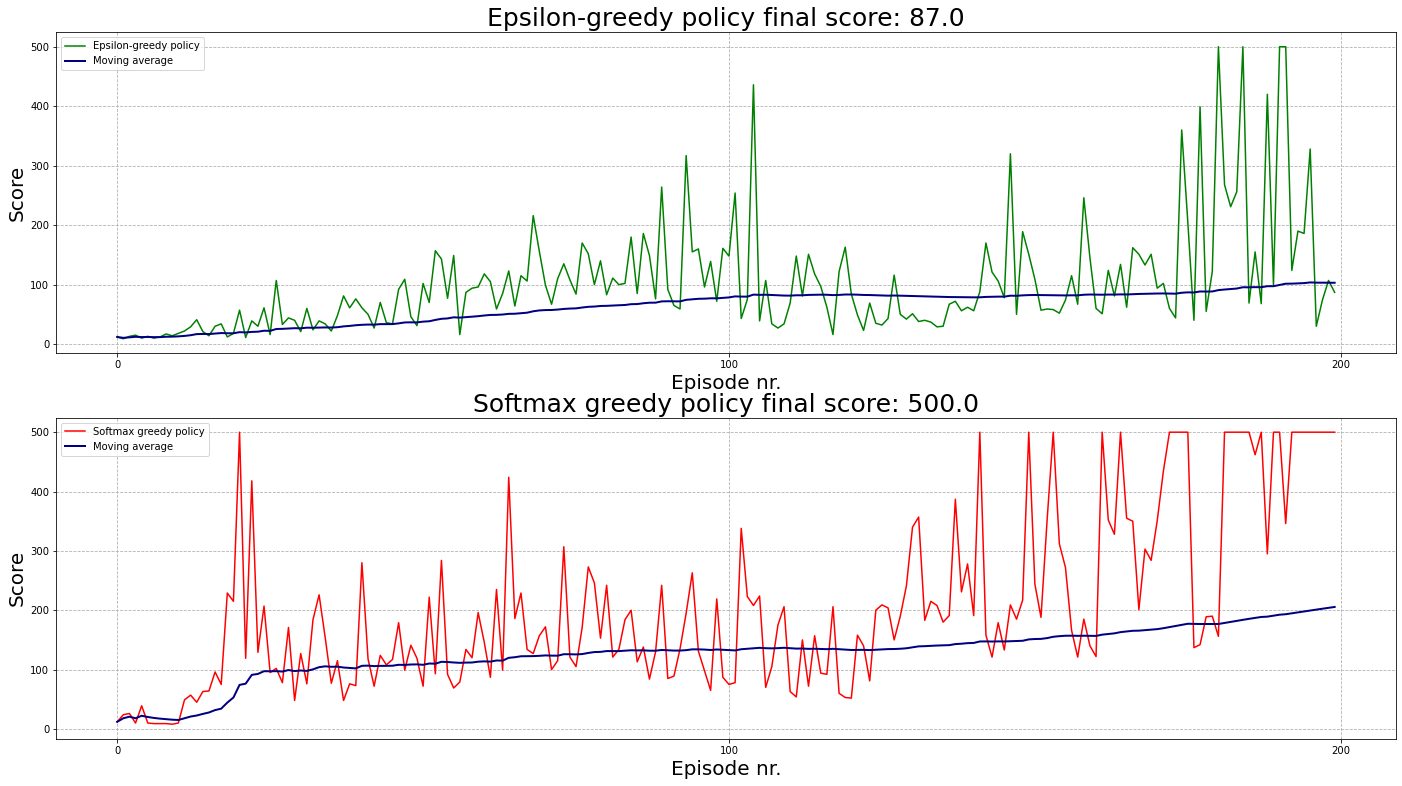

In [ ]:
# compute the moving averages
eps_ave = np.cumsum(history_e)/np.arange(1,len(history_e)+1,1) 
soft_ave = np.cumsum(history_s)/np.arange(1,len(history_s)+1,1)

fig , ax = plt.subplots(2,1,figsize=(24,13))

ax[0].plot(history_e, color='green', label='Epsilon-greedy policy')
ax[0].plot(eps_ave, color='navy', label='Moving average', linewidth=2)
ax[0].grid(linestyle='--')
ax[0].legend()
ax[0].set_xticks(np.arange(0,len(exploration_profile_epsilon)+1,100))
ax[0].set_title(f'Epsilon-greedy policy final score: %0.1f' %history_e[-1], fontsize=25)
ax[0].set_xlabel('Episode nr.', fontsize=20)
ax[0].set_ylabel('Score', fontsize=20);

ax[1].plot(history_s, color='red', label='Softmax greedy policy')
ax[1].plot(soft_ave, color='navy', label='Moving average', linewidth=2)
ax[1].grid(linestyle='--')
ax[1].legend()
ax[1].set_xticks(np.arange(0,len(exploration_profile_epsilon)+1,100))
ax[1].set_title(f'Softmax greedy policy final score: %0.1f' %history_s[-1], fontsize=25)
ax[1].set_xlabel('Episode nr.', fontsize=20)
ax[1].set_ylabel('Score', fontsize=20);

In [ ]:
# Display the videos, not required outside Colab
#show_videos()

### Exploration profile impact on training

#### High exploration, low exploitation

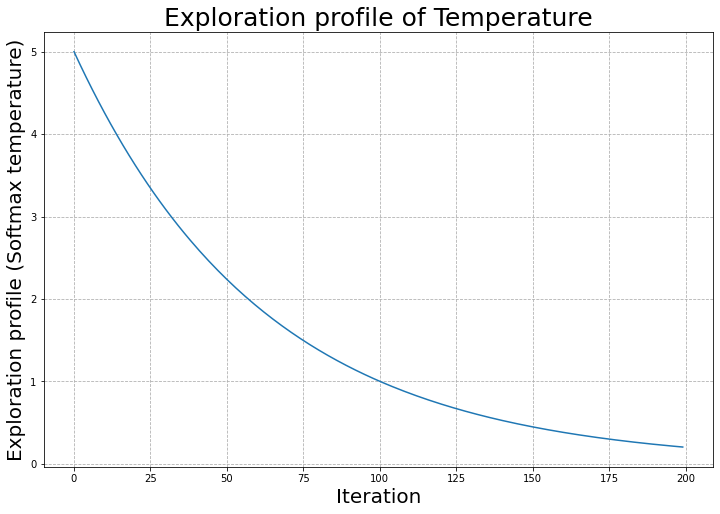

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 200
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 2) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile_softmax = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile_softmax)
plt.grid(linestyle='--')
plt.title('Exploration profile of Temperature', fontsize=25)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Exploration profile (Softmax temperature)', fontsize=20);

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Initialize the Gym environment
start = time.time()
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes
history_s = []
completed = -1
for episode_num, tau in enumerate(tqdm(exploration_profile_softmax)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      state_weight = [-100, -50, 0, -100]
      reward += state_weight[0] * np.abs(state[0]) # cart position
      reward += state_weight[1] * np.abs(state[1]) # cart velocity
      reward += state_weight[2] * np.abs(state[2]) # pole angle
      reward += state_weight[3] * np.abs(state[3]) # pole angle velocity
      if done: 
        reward += bad_state_penalty # bad penalty if pole has fallen down
        next_state = None
      else: reward += 0 # positive reward if it is still alive


      # Update the final score (+1 for each step)
      score += 1

      # Update the replay memorym])
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    history_s.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    if (score == 500) &  (completed < 0):
        torch.save(policy_net.state_dict(), './soft_cartpolev1.pth')
        completed = episode_num + 1
env.close()
end = time.time()

print(f'\nTotal training time: %0.3f' %(end-start))
print(f'Completed in: %0.0f episodes' %completed)
print(f'Final score: %0.1f' %history_s[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 4.920172216817288
EPISODE: 3 - FINAL SCORE: 26 - Temperature: 4.841618928628149
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 4.76431978741058
EPISODE: 5 - FINAL SCORE: 39 - Temperature: 4.688254770010077
Updating target network...
EPISODE: 6 - FINAL SCORE: 10 - Temperature: 4.613404172952941
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 4.5397486073424
EPISODE: 8 - FINAL SCORE: 9 - Temperature: 4.46726899383621
EPISODE: 9 - FINAL SCORE: 9 - Temperature: 4.395946557704448
EPISODE: 10 - FINAL SCORE: 8 - Temperature: 4.325762823966204
Updating target network...
EPISODE: 11 - FINAL SCORE: 10 - Temperature: 4.256699612603922
EPISODE: 12 - FINAL SCORE: 50 - Temperature: 4.188739033854146
EPISODE: 13 - FINAL SCORE: 43 - Temperature: 4.121863483573451
EPISODE: 14 - FINAL SCORE: 66 - Temperature: 4.056055638678363
EPISODE: 15 - FINAL SCORE: 66 - Temperature: 3.991298452658077
Updat

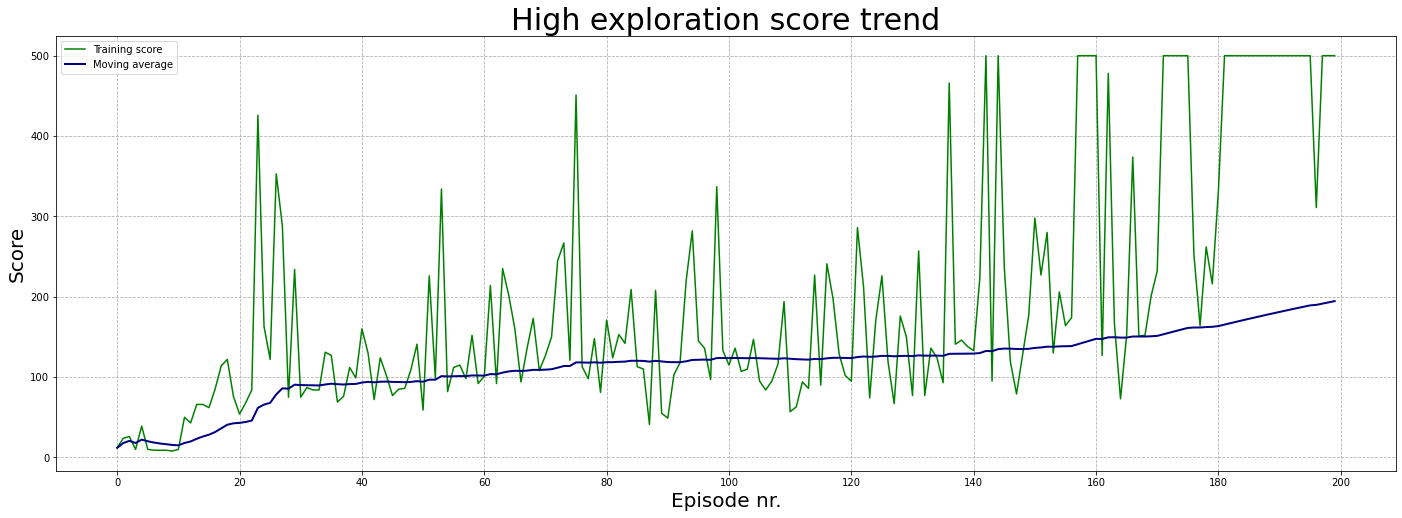

In [ ]:
soft_ave = np.cumsum(history_s)/np.arange(1,len(history_s)+1,1)

plt.figure(figsize=(24,8))
plt.plot(history_s, color='green', label='Training score')
plt.plot(soft_ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend()
plt.xticks(np.arange(0,len(exploration_profile_softmax)+1,20))
plt.title('High exploration score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
# Set a random seeds (reproducible results)
env.seed(seed) 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
solved = 'solved'

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    if score <= 195 : solved = 'not solved'
env.close()

print('\nThe game is', solved)

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 456.0
EPISODE 3 - FINAL SCORE: 457.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 454.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 456.0
EPISODE 10 - FINAL SCORE: 500.0
EPISODE 11 - FINAL SCORE: 500.0
EPISODE 12 - FINAL SCORE: 409.0
EPISODE 13 - FINAL SCORE: 500.0
EPISODE 14 - FINAL SCORE: 409.0
EPISODE 15 - FINAL SCORE: 500.0
EPISODE 16 - FINAL SCORE: 444.0
EPISODE 17 - FINAL SCORE: 333.0
EPISODE 18 - FINAL SCORE: 500.0
EPISODE 19 - FINAL SCORE: 500.0
EPISODE 20 - FINAL SCORE: 500.0
EPISODE 21 - FINAL SCORE: 500.0
EPISODE 22 - FINAL SCORE: 500.0
EPISODE 23 - FINAL SCORE: 500.0
EPISODE 24 - FINAL SCORE: 482.0
EPISODE 25 - FINAL SCORE: 500.0
EPISODE 26 - FINAL SCORE: 410.0
EPISODE 27 - FINAL SCORE: 499.0
EPISODE 28 - FINAL SCORE: 452.0
EPISODE 29 - FINAL SCORE: 500.0
EPISODE 30 - FINAL SCORE: 500.0
EPISODE 31 - FINAL SCORE: 500.0
EPISODE 32 - FINA

#### Low exploration, high exploitation

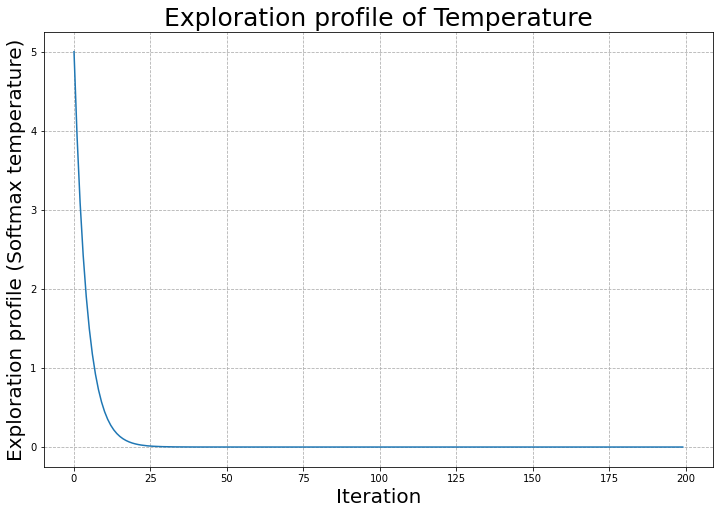

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 200
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 30) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile_softmax = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile_softmax)
plt.grid(linestyle='--')
plt.title('Exploration profile of Temperature', fontsize=25)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Exploration profile (Softmax temperature)', fontsize=20);

In [ ]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Initialize the Gym environment
start = time.time()
env = gym.make('CartPole-v1') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 10 == 0) # Save a video every 100 episodes
history_s = []
completed = -1
for episode_num, tau in enumerate(tqdm(exploration_profile_softmax)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      state_weight = [-100, -50, 0, -100]
      reward += state_weight[0] * np.abs(state[0]) # cart position
      reward += state_weight[1] * np.abs(state[1]) # cart velocity
      reward += state_weight[2] * np.abs(state[2]) # pole angle
      reward += state_weight[3] * np.abs(state[3]) # pole angle velocity
      if done: 
        reward += bad_state_penalty # bad penalty if pole has fallen down
        next_state = None
      else: reward += 0 # positive reward if it is still alive


      # Update the final score (+1 for each step)
      score += 1

      # Update the replay memorym])
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    history_s.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    if (score == 500) &  (completed < 0):
        torch.save(policy_net.state_dict(), './soft_cartpolev1.pth')
        completed = episode_num + 1
env.close()
end = time.time()

print(f'\nTotal training time: %0.3f' %(end-start))
print(f'Completed in: %0.0f episodes' %completed)
print(f'Final score: %0.1f' %history_s[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 3.927575151158822
EPISODE: 3 - FINAL SCORE: 26 - Temperature: 3.0851693136000486
EPISODE: 4 - FINAL SCORE: 10 - Temperature: 2.423446866642654
EPISODE: 5 - FINAL SCORE: 37 - Temperature: 1.903653938715879
Updating target network...
EPISODE: 6 - FINAL SCORE: 10 - Temperature: 1.495348781221221
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 1.1746189430880196
EPISODE: 8 - FINAL SCORE: 9 - Temperature: 0.9226808345905888
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.724779663677696
EPISODE: 10 - FINAL SCORE: 8 - Temperature: 0.5693253194251533
Updating target network...
EPISODE: 11 - FINAL SCORE: 10 - Temperature: 0.4472135954999582
EPISODE: 12 - FINAL SCORE: 42 - Temperature: 0.35129300098920574
EPISODE: 13 - FINAL SCORE: 67 - Temperature: 0.2759459322922432
EPISODE: 14 - FINAL SCORE: 62 - Temperature: 0.21675967734687382
EPISODE: 15 - FINAL SCORE: 73 - Temperature: 0.170267

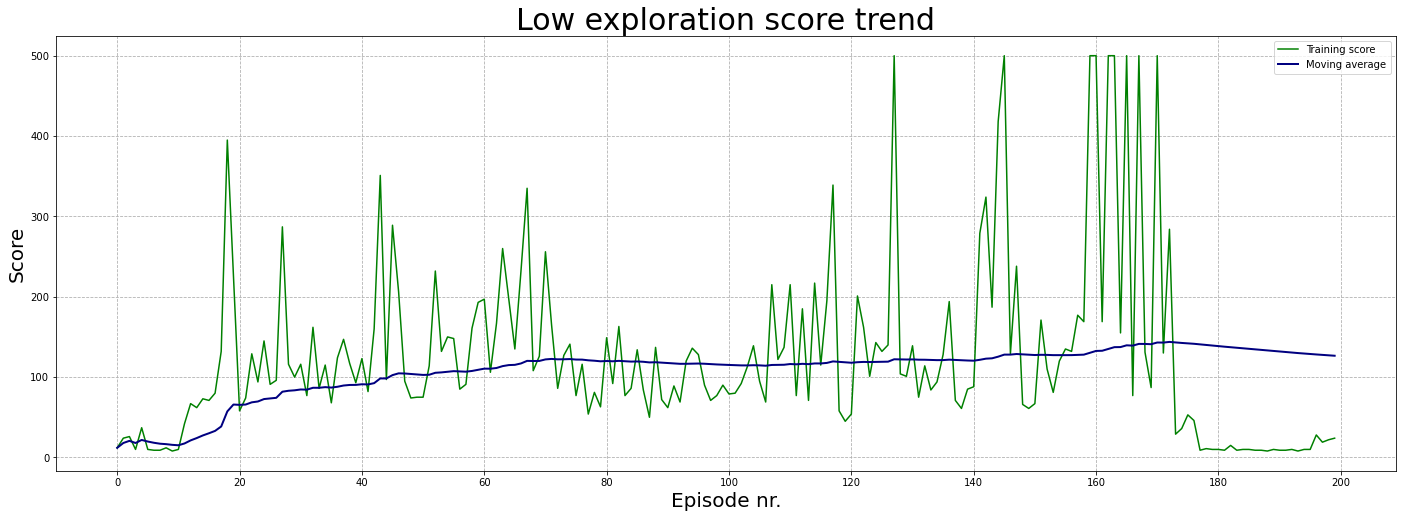

In [ ]:
soft_ave = np.cumsum(history_s)/np.arange(1,len(history_s)+1,1)

plt.figure(figsize=(24,8))
plt.plot(history_s, color='green', label='Training score')
plt.plot(soft_ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend()
plt.xticks(np.arange(0,len(exploration_profile_softmax)+1,20))
plt.title('Low exploration score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
# Set a random seeds (reproducible results)
env.seed(seed) 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
solved = 'solved'

# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      #env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    if score <= 195 : solved = 'not solved'
env.close()

print('\nThe game is', solved)

EPISODE 1 - FINAL SCORE: 31.0
EPISODE 2 - FINAL SCORE: 32.0
EPISODE 3 - FINAL SCORE: 51.0
EPISODE 4 - FINAL SCORE: 47.0
EPISODE 5 - FINAL SCORE: 29.0
EPISODE 6 - FINAL SCORE: 30.0
EPISODE 7 - FINAL SCORE: 27.0
EPISODE 8 - FINAL SCORE: 23.0
EPISODE 9 - FINAL SCORE: 21.0
EPISODE 10 - FINAL SCORE: 21.0
EPISODE 11 - FINAL SCORE: 40.0
EPISODE 12 - FINAL SCORE: 32.0
EPISODE 13 - FINAL SCORE: 19.0
EPISODE 14 - FINAL SCORE: 21.0
EPISODE 15 - FINAL SCORE: 31.0
EPISODE 16 - FINAL SCORE: 41.0
EPISODE 17 - FINAL SCORE: 33.0
EPISODE 18 - FINAL SCORE: 28.0
EPISODE 19 - FINAL SCORE: 29.0
EPISODE 20 - FINAL SCORE: 34.0
EPISODE 21 - FINAL SCORE: 22.0
EPISODE 22 - FINAL SCORE: 27.0
EPISODE 23 - FINAL SCORE: 24.0
EPISODE 24 - FINAL SCORE: 40.0
EPISODE 25 - FINAL SCORE: 37.0
EPISODE 26 - FINAL SCORE: 45.0
EPISODE 27 - FINAL SCORE: 43.0
EPISODE 28 - FINAL SCORE: 25.0
EPISODE 29 - FINAL SCORE: 19.0
EPISODE 30 - FINAL SCORE: 44.0
EPISODE 31 - FINAL SCORE: 21.0
EPISODE 32 - FINAL SCORE: 21.0
EPISODE 33 - FINA

# MsPacman-v0

### ROMs

import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

In [9]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

### Load env

from google.colab import drive
drive.mount('/content/drive')

In [9]:
### Create environment
env = gym.make('MsPacman-v0').unwrapped # Initialize the Gym environment
env.seed(seed) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_size = env.observation_space.shape
action_size = env.action_space.n

print(f"STATE SPACE SIZE: {state_size}")
print(f"ACTION SPACE SIZE: {action_size}")

size = (100,90,3)

STATE SPACE SIZE: (210, 160, 3)
ACTION SPACE SIZE: 9


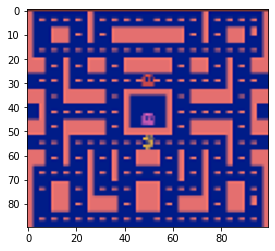

In [10]:
screen = np.array(env.render('rgb_array'))
res = cv2.resize(screen[:170,:,:], dsize=(100, 90), interpolation=cv2.INTER_CUBIC)

#screen = np.array(env.render('rgb_array')) #.transpose(2,0,1)
#screen = np.resize(screen, (80,85,3))
plt.imshow(res) #.squeeze(0).permute(1,2,0), interpolation='none')

In [11]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))
        #return self.memory

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Define DQN

In [13]:
class DQN(nn.Module):

    def __init__(self, state_space, action_space):
        super().__init__()

        self.convolution1 = nn.Conv2d(in_channels=state_space[2], out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=256) # 2560 full image, 1920 in 170x160
        #self.fc2 = nn.Linear(in_features=256, out_features=128)
        #self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=action_space)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
    def forward(self, x):
        x = x.to(device)
        x = self.relu(self.maxpool1(self.convolution1(x)))
        x = self.relu(self.maxpool1(self.convolution2(x)))
        x = self.relu(self.maxpool2(self.convolution3(x)))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [14]:
net = DQN(state_space=state_size, action_space=5).to(device) # action_size

### Random agent

In [ ]:
# Initialize the Gym environment
env = gym.make('MsPacman-v0').unwrapped # Initialize the Gym environment
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True)
history = [0]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score
    score = 0
    done = False
    
    while not done and score < 1000:
      # Choose a random action
      action = random.choice(np.arange(0,9,1))
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      #print(info)
      # Visually render the environment
      #env.render('human')
      # Update the final score
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    history.append(score)

env.close()

EPISODE 1 - FINAL SCORE: 160.0
EPISODE 2 - FINAL SCORE: 180.0
EPISODE 3 - FINAL SCORE: 100.0
EPISODE 4 - FINAL SCORE: 650.0
EPISODE 5 - FINAL SCORE: 280.0
EPISODE 6 - FINAL SCORE: 240.0
EPISODE 7 - FINAL SCORE: 200.0
EPISODE 8 - FINAL SCORE: 180.0
EPISODE 9 - FINAL SCORE: 200.0
EPISODE 10 - FINAL SCORE: 160.0


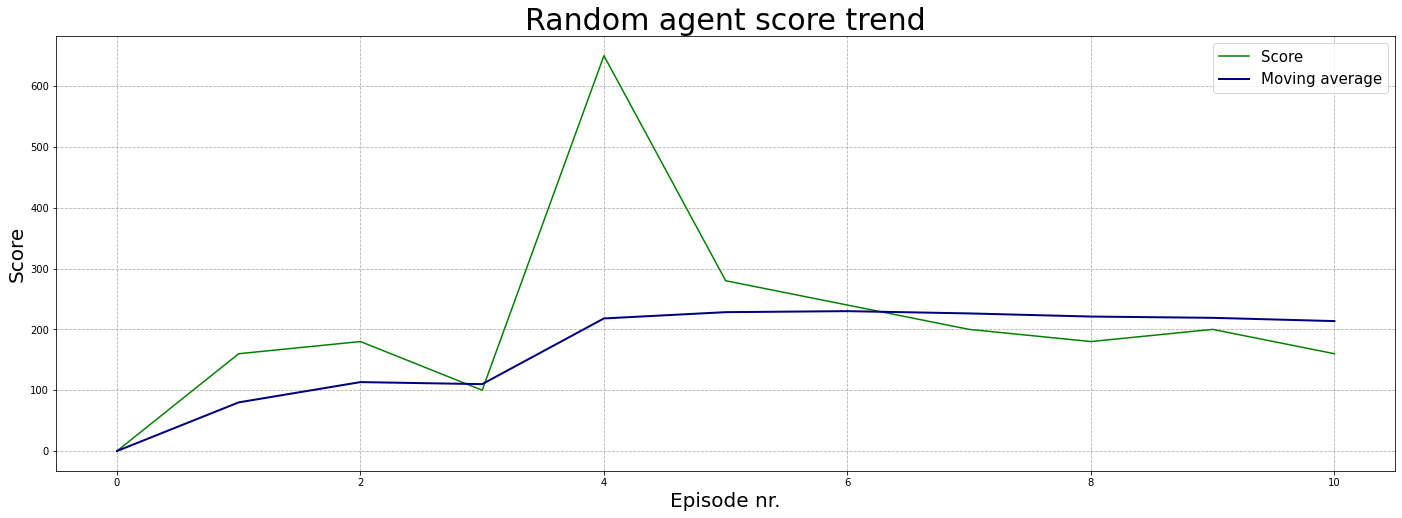

In [ ]:
ave = np.cumsum(history)/np.arange(1, len(history)+1, 1)

plt.figure(figsize=(24,8))
plt.plot(history, color='green', label='Score')
plt.plot(ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend(fontsize=15)
plt.title('Random agent score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [ ]:
#show_videos()

### Define Policy

In [15]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=1).squeeze().cpu().numpy()
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

In [16]:
state = torch.rand(size=(3,100,90)).unsqueeze(0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [[ 0.05415902  0.11896954 -0.03565995 -0.11079012  0.12154608]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [17]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    epsilon = max(epsilon, 0.05)
    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        #all_possible_actions = np.arange(0, action_space_dim) + 1
        #non_optimal_actions = all_possible_actions.remove(best_action)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [18]:
# Test if it works as expected
state = torch.rand(size=(3,100,90)).unsqueeze(0)
epsilon = 1.0
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 3
Q-VALUES: [[ 0.05468868  0.11885663 -0.0351689  -0.11164796  0.12107582]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


### Define parameters

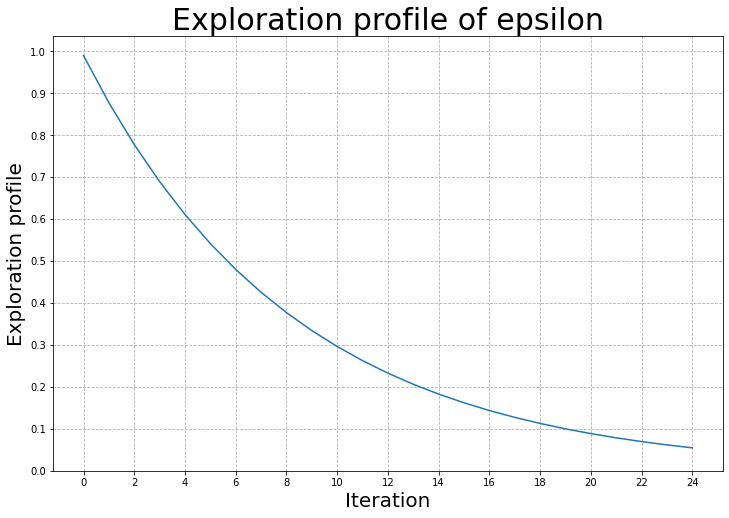

In [19]:
### Define exploration profile
initial_value = 0.99
num_iterations = 25
# We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exp_decay = np.exp(np.log(initial_value) / num_iterations * 300)
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid(linestyle='--')
plt.xticks(np.arange(0,26,2))
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Exploration profile of epsilon', fontsize=30)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Exploration profile', fontsize=20);

In [20]:
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 2.5e-4   # Optimizer learning rate
target_net_update_steps = 5  # Number of episodes to wait before updating the target network
batch_size = 64   # Number of samples to take from the replay memory for each update
min_samples_for_training = 100  # Minimum samples in the replay memory to enable the training

In [21]:
### Initialize the replay memories
replay_mem_p = ReplayMemory(replay_memory_capacity)
replay_mem_n = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_size, 5).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_size, 5).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss() # nn.MSELoss() 

### Define updating procedure

In [22]:
def update_step(policy_net, target_net, replay_mem_p, replay_mem_n, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    if len(replay_mem_n) > batch_size/2:
      batch_p = replay_mem_p.sample(59)
      batch_n = replay_mem_n.sample(5)
      batch = random.sample((batch_p+batch_n), batch_size)
      batch_size = len(batch)
    else :       
      batch = replay_mem_p.sample(batch_size)
      batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32).view((batch_size,3,100,90))
    actions     = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards     = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32).view((batch_size,3,100,90)) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.cpu().gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.cpu().max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    # save params
    torch.save(policy_net.state_dict(), '/content/drive/MyDrive/università/Lab_NNDL/Homework 3-20211213/MsPacman.pth')
    #'/content/drive/MyDrive/università/Lab_NNDL/Homework 3-20211213/MsPacman.pth'
    # '/content/drive/MyDrive/Homework 3-20211213/MsPacman.pth'
    # './MsPacman.pth'

### Training

In [23]:
def total_reward(reward, action, old_action):
    turn_reward = reward
    
    reward += 10 if turn_reward == 10 else 0 # ate a pill
    reward += 5 if turn_reward == 50 else 0 # ate a powerpill
    #reward += 500 if turn_reward == 1520 else 0 # has eaten all pills and powerpills
    reward += 30 if turn_reward == 200 else 0 # ate a ghost
    reward += -6 if old_action != action else 0 # reversed on her path
    reward += -350 if dead else 0 # lost a life
    reward += -5 # step penalty # -5
    #reward += 50 if score > time else 0
    
    return reward

In [24]:
# load the old parameters
net_path = '/content/drive/MyDrive/università/Lab_NNDL/Homework 3-20211213/MsPacman.pth' #'./MsPacman.pth' #'/content/drive/MyDrive/Homework 3-20211213/MsPacman.pth' 
policy_net.load_state_dict(torch.load(net_path))

<All keys matched successfully>

In [25]:
# Initialize the Gym environment
env = gym.make('MsPacman-v0').unwrapped 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 10 == 0) # Save a video every n episodes
EPOCHS = len(exploration_profile)
history = [0]
start = time.time()
for episode_num, eps in enumerate(tqdm(exploration_profile)):

    done = False
    score = 0
    lives = 3
    old_action = random.choice(np.arange(0,5,1))
    
    # Reset the environment and get the initial state
    state = env.reset()
    state = cv2.resize(state[:170,:,:], dsize=(100, 90), interpolation=cv2.INTER_CUBIC) # crop and rescale
    state = np.reshape(state, (1, 100, 90,3)).transpose(0,3,1,2)/255 # normalize

    for t in range(10000000):
      #print(t)

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, eps) 
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      ### assign reward
      score += reward
      dead = info['ale.lives'] < lives
      lives = info['ale.lives']

      ### REWARDS
      reward = total_reward(reward, action, old_action)
      
      #if episode_num % 5 == 0:
        #print(turn_reward)
        #print(reward)

      old_action = action
      next_state = cv2.resize(next_state[:170,:,:], dsize=(100, 90), interpolation=cv2.INTER_CUBIC) # crop and rescale
      next_state = np.reshape(next_state, (1, 100, 90, 3)).transpose(0,3,1,2)/255 # normalize
      

      # Update the replay memory
      if reward >= 0:
        replay_mem_p.push(state, action, next_state, reward)
      else:
        replay_mem_n.push(state, action, next_state, reward)

      # Visually render the environment (disable to speed up the training)
      #if episode_num % 10 == 0: 
      #env.render()
        
      # Update the network
      # we enable the training only if we have enough samples in the replay memory, 
      #otherwise the training will use the same samples too often
      if (len(replay_mem_p) > min_samples_for_training) & (len(replay_mem_n) > min_samples_for_training/2): 
        update_step(policy_net, target_net, replay_mem_p, replay_mem_n, gamma, optimizer, loss_fn, batch_size)

      # Set the current state for the next iteration
      state = next_state - state # take the difference
      
      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
        #print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) 
        
      if eps < 0.05: eps = 0.05 # minimum epsilon
      if done:
        #target_net.load_state_dict(policy_net.state_dict())
        print("Episode: {}/{}, score: {}, time: {}, epsilon: {:.2}".format(episode_num+1, EPOCHS, 
                                                                            score, t, eps))
        history.append(score)
        break

env.close()

end = time.time()
print(f'\nTotal training time: %0.2f' %(end-start))

  0%|          | 0/25 [00:00<?, ?it/s]

Episode: 1/25, score: 180.0, time: 499, epsilon: 0.99
Episode: 2/25, score: 130.0, time: 666, epsilon: 0.88
Episode: 3/25, score: 190.0, time: 594, epsilon: 0.78
Episode: 4/25, score: 170.0, time: 704, epsilon: 0.69
Episode: 5/25, score: 240.0, time: 638, epsilon: 0.61
Episode: 6/25, score: 300.0, time: 748, epsilon: 0.54
Episode: 7/25, score: 230.0, time: 704, epsilon: 0.48
Episode: 8/25, score: 330.0, time: 575, epsilon: 0.43
Episode: 9/25, score: 1020.0, time: 1190, epsilon: 0.38
Episode: 10/25, score: 460.0, time: 991, epsilon: 0.33
Episode: 11/25, score: 360.0, time: 655, epsilon: 0.3
Episode: 12/25, score: 570.0, time: 910, epsilon: 0.26
Episode: 13/25, score: 890.0, time: 1037, epsilon: 0.23
Episode: 14/25, score: 520.0, time: 937, epsilon: 0.21
Episode: 15/25, score: 240.0, time: 543, epsilon: 0.18
Episode: 16/25, score: 470.0, time: 842, epsilon: 0.16
Episode: 17/25, score: 430.0, time: 685, epsilon: 0.14
Episode: 18/25, score: 300.0, time: 716, epsilon: 0.13
Episode: 19/25, s

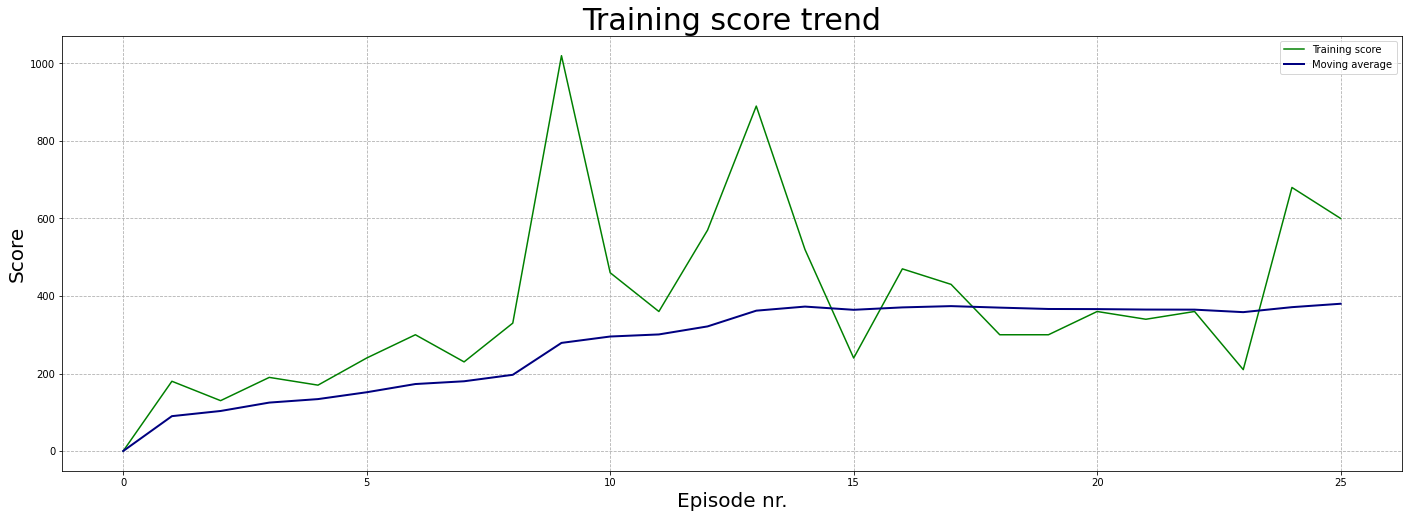

In [26]:
ave = np.cumsum(history)/np.arange(1,len(history)+1,1)

plt.figure(figsize=(24,8))
plt.plot(history, color='green', label='Training score')
plt.plot(ave, color='navy', label='Moving average', linewidth=2)
plt.grid(linestyle='--')
plt.legend()
plt.xticks(np.arange(0, len(exploration_profile)+1, 5))
plt.title('Training score trend', fontsize=30)
plt.xlabel('Episode nr.', fontsize=20)
plt.ylabel('Score', fontsize=20);

In [27]:
#show_videos()

In [28]:
# load the old parameters
net_path = '/content/drive/MyDrive/università/Lab_NNDL/Homework 3-20211213/MsPacman.pth' #'./MsPacman.pth' #'/content/drive/MyDrive/Homework 3-20211213/MsPacman.pth' #'/content/drive/MyDrive/università/Lab_NNDL/Homework 3-20211213/MsPacman.pth'
policy_net.load_state_dict(torch.load(net_path))

<All keys matched successfully>

In [31]:
# Initialize the Gym environment
env = gym.make('MsPacman-v0') 
env.seed(seed) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
history_test = []

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    state = cv2.resize(state[:170,:,:], dsize=(100, 90), interpolation=cv2.INTER_CUBIC)
    state = np.reshape(state, (1, 100, 90,3)).transpose(0,3,1,2)/255
    # Reset the score
    score = 0
    done = False
    
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      
      score += reward 
      # Set the current state for the next iteration
      next_state = cv2.resize(next_state[:170,:,:], dsize=(100, 90), interpolation=cv2.INTER_CUBIC) # rescale
      next_state = np.reshape(next_state, (1, 100, 90, 3)).transpose(0,3,1,2)/255 # crop and normalize
      state = next_state - state
      
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}")
    history_test.append(score)
env.close()

print(f'\nAverage score: %0.1f' %(np.mean(history_test)))

EPISODE 1 - FINAL SCORE: 780.0
EPISODE 2 - FINAL SCORE: 180.0
EPISODE 3 - FINAL SCORE: 380.0
EPISODE 4 - FINAL SCORE: 120.0
EPISODE 5 - FINAL SCORE: 780.0
EPISODE 6 - FINAL SCORE: 110.0
EPISODE 7 - FINAL SCORE: 140.0
EPISODE 8 - FINAL SCORE: 380.0
EPISODE 9 - FINAL SCORE: 110.0
EPISODE 10 - FINAL SCORE: 220.0

Average score: 320.0
